In [303]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

  # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [216]:
#set path to Features CSV and read in CSV
amd_df = pd.read_pickle('Resources/amd_features_df.pickle')
amd_df.head()

,AMD Close,AMD Volume,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rvol,rvol SD,rvol signal,daily returns
2019-07-26,34.01,40369473,32.8090,1.163419,33.972419,31.645581,0.0,-1.0,-1.0,0.912169,0.913205,0.0,0.010398
2019-07-29,33.48,42767769,32.9640,1.020501,33.984501,31.943499,0.0,0.0,0.0,0.962055,0.931985,1.0,-0.015584
2019-07-30,33.87,54286925,33.0975,0.949785,34.047285,32.147715,0.0,0.0,0.0,1.222984,0.963948,1.0,0.011649
2019-07-31,30.43,110558754,33.0560,1.047414,34.103414,32.008586,1.0,0.0,1.0,2.296310,1.130589,1.0,-0.101565
2019-08-01,29.86,76711829,32.9900,1.202024,34.192024,31.787976,1.0,0.0,1.0,1.506163,1.185642,1.0,-0.018732


In [275]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [281]:
#add daily change rates to increase the staionarity of dataset
trading_signals_df['volume delta'] = amd_df['AMD Volume'].dropna().pct_change()
trading_signals_df['bb std delta'] = amd_df['bollinger_std'].dropna().pct_change()
trading_signals_df['bb rvol delta'] = amd_df['rvol'].dropna().pct_change()

#add daily returns as target
trading_signals_df['daily returns'] = amd_df['daily returns'].dropna()

trading_signals_df= trading_signals_df.dropna()
trading_signals_df.head()

,volume delta,bb std delta,bb rvol delta,daily returns
2019-07-29,0.059409,-0.122843,0.054690,-0.015584
2019-07-30,0.269342,-0.069296,0.271220,0.011649
2019-07-31,1.036563,0.102791,0.877630,-0.101565
2019-08-01,-0.306144,0.147611,-0.344094,-0.018732
2019-08-02,-0.388955,0.168094,-0.397970,-0.013396


In [282]:
 def window_data(window):
    """
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(trading_signals_df) - window):
        features = trading_signals_df.iloc[i : (i + window), :]
        target = trading_signals_df.iloc[(i + window), -1]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [283]:
# Define the window size
window_size = 7

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(window_size)



In [285]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [286]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])



In [287]:
scaler = MinMaxScaler()
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [288]:
# Define the Transformer model.
model = Sequential()

# Initial model setup
number_units = 7
dropout_fraction = 0.3
inputs = len(trading_signals_df.columns)

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X.shape[1], inputs))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [289]:
# Compile the LSTM model
model.compile(optimizer="adam", loss="mean_squared_error")

In [290]:
# Show the model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 7)              336       
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7, 7)              420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_59 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)               

In [291]:
 # Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0)

In [292]:
 # Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [293]:
#Recover the original, nonscaled prices
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [294]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = trading_signals_df.index[-len(real_prices): ]) 


# Show the DataFrame's head
stocks

,Actual,Predicted
2019-11-14,0.022394,0.000919
2019-11-15,0.005215,0.000837
2019-11-18,0.034890,0.001531
2019-11-19,0.034716,0.001597
2019-11-20,-0.007510,0.002038
2019-11-21,-0.035863,0.002126
2019-11-22,-0.009131,0.001837
2019-11-25,0.016863,0.001632
2019-11-26,-0.020854,0.001578
2019-11-27,0.011291,0.001534


In [299]:
#convert stocks df into positive and negative signals
stocks['Positive Actual signal'] = np.where(stocks['Actual'] > 0, 1, 0)
stocks['Negative Actual signal'] = np.where(stocks['Actual'] < 0, -1, 0)

stocks['Positive Predicted signal'] = np.where(stocks['Predicted'] > 0, 1, 0)
stocks['Negative Predicted signal'] = np.where(stocks['Predicted'] < 0, -1, 0)

#merge to create one column per signal
stocks['Actual Signal'] = stocks['Positive Actual signal'] + stocks['Negative Actual signal']
stocks['Predicted Signal'] = stocks['Positive Predicted signal'] + stocks['Negative Predicted signal']
stocks.head()

,Actual,Predicted,Positive Actual signal,Negative Actual signal,Positive Predicted signal,Negative Predicted signal,Actual Signal,Predicted Signal
2019-11-14,0.022394,0.000919,1,0,1,0,1,1
2019-11-15,0.005215,0.000837,1,0,1,0,1,1
2019-11-18,0.034890,0.001531,1,0,1,0,1,1
2019-11-19,0.034716,0.001597,1,0,1,0,1,1
2019-11-20,-0.007510,0.002038,0,-1,1,0,-1,1


<AxesSubplot:>

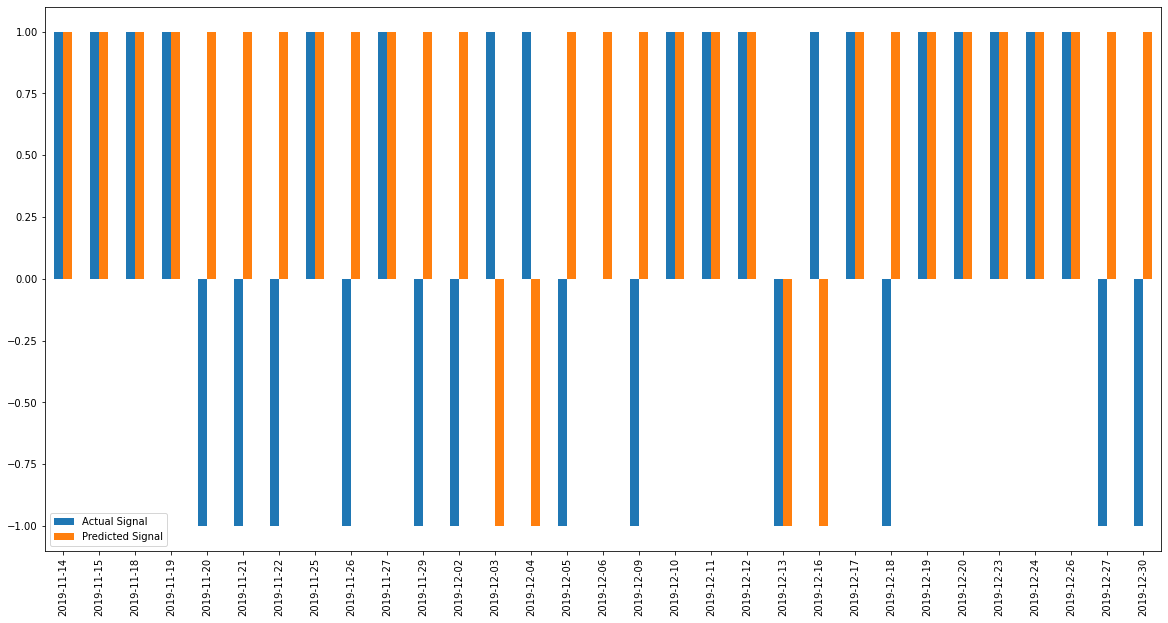

In [310]:
stocks.plot(y = ['Actual Signal', 'Predicted Signal'], figsize = (20,10), kind = 'bar')

<AxesSubplot:>

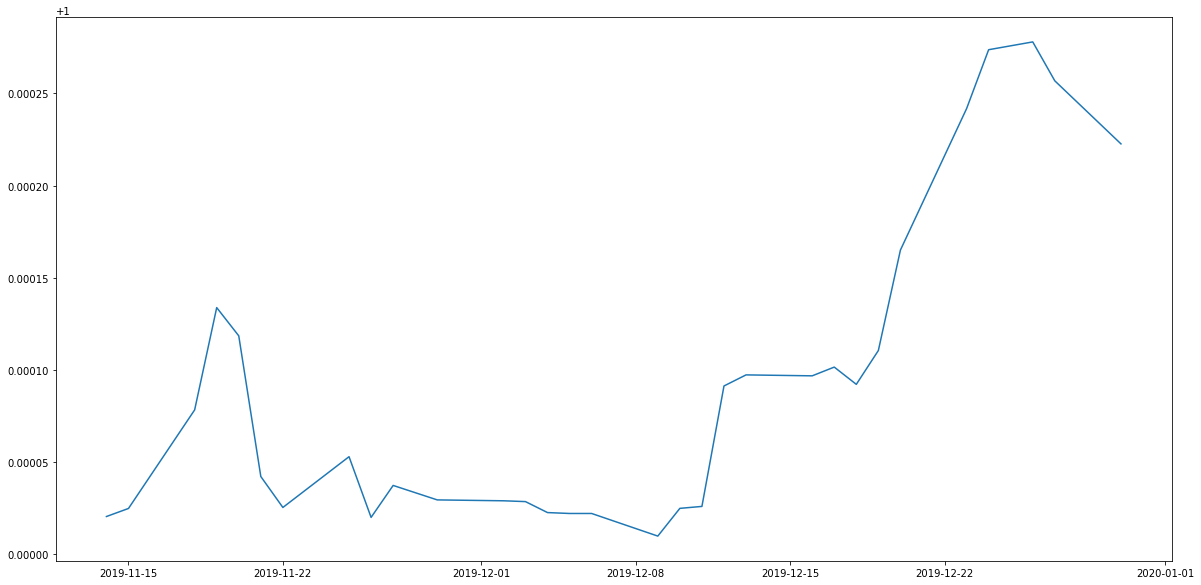

In [314]:
# Calculate cumulative return of model and plot the result
(1 + (stocks['Actual'] * stocks['Predicted'])).cumprod().plot(figsize = (20,10))

<AxesSubplot:>

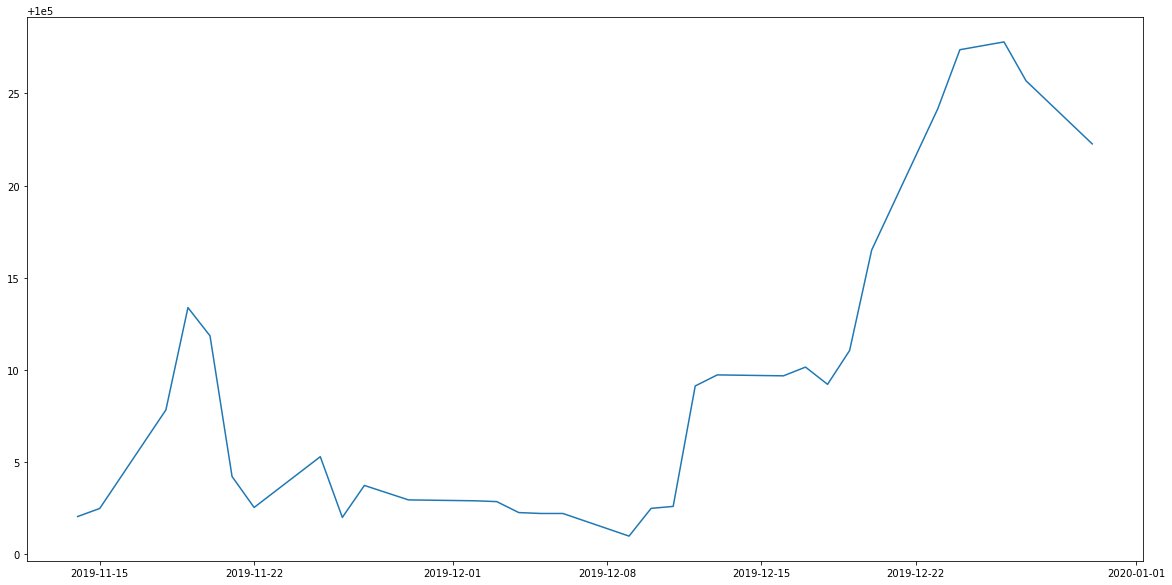

In [313]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (stocks['Actual'] * stocks['Predicted'])).cumprod()
cumulative_return_capital.plot(figsize = (20,10))